In [20]:
import pandas as pd
import numpy as np
from collections import Counter
import networkx as nx
import random
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import folium
#import geojson
import json
from geopy import distance
#import geopandas

In [3]:
airport_info = pd.read_csv("../../Data/us-airports.csv",delimiter=",")

In [30]:
airport_info

,id,ident,type,name,latitude_deg,longitude_deg,elevation_ft,continent,country_name,iso_country,...,municipality,scheduled_service,gps_code,iata_code,local_code,home_link,wikipedia_link,keywords,score,last_updated
0,#meta +id,#meta +code,#loc +airport +type,#loc +airport +name,#geo +lat,#geo +lon,#geo +elevation +ft,#region +continent +code,#country +name,#country +code +iso2,...,#loc +municipality +name,#status +scheduled,#loc +airport +code +gps,#loc +airport +code +iata,#loc +airport +code +local,#meta +url +airport,#meta +url +wikipedia,#meta +keywords,#meta +score,#date +updated
1,3632,KLAX,large_airport,Los Angeles International Airport,33.942501,-118.407997,125,NaN,United States,US,...,Los Angeles,1,KLAX,LAX,LAX,https://www.flylax.com/,https://en.wikipedia.org/wiki/Los_Angeles_Inte...,NaN,1335475,2020-04-26T22:37:22+00:00
2,3754,KORD,large_airport,Chicago O'Hare International Airport,41.9786,-87.9048,672,NaN,United States,US,...,Chicago,1,KORD,ORD,ORD,https://www.flychicago.com/ohare/home/pages/de...,https://en.wikipedia.org/wiki/O'Hare_Internati...,"CHI, Orchard Place",1503175,2018-09-16T02:35:35+00:00
3,3622,KJFK,large_airport,John F Kennedy International Airport,40.639801,-73.7789,13,NaN,United States,US,...,New York,1,KJFK,JFK,JFK,https://www.jfkairport.com/,https://en.wikipedia.org/wiki/John_F._Kennedy_...,"Manhattan, New York City, NYC, Idlewild",1052075,2021-04-10T17:02:47+00:00
4,3384,KATL,large_airport,Hartsfield Jackson Atlanta International Airport,33.6367,-84.428101,1026,NaN,United States,US,...,Atlanta,1,KATL,ATL,ATL,http://www.atlanta-airport.com/,https://en.wikipedia.org/wiki/Hartsfield–Jacks...,NaN,2002475,2018-09-19T14:50:01+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27636,322813,US-0527,heliport,AdventHealth Zephyrhills Heliport,28.261934,-82.185663,160,NaN,United States,US,...,Zephyrhills,0,FD75,NaN,FD75,NaN,NaN,Florida Hospital Zephyrhills Heliport,0,2021-06-11T17:55:06+00:00
27637,345570,08NR,small_airport,Bell Mountain Airport,35.217541,-82.426,2150,NaN,United States,US,...,Zirconia,0,08NR,NaN,08NR,NaN,NaN,NaN,0,2021-06-19T14:33:13+00:00
27638,324916,US-0652,heliport,Rotary Run Heliport,40.605805,-81.415002,1027,NaN,United States,US,...,Zoar,0,NaN,NaN,0OH2,NaN,NaN,NaN,0,2017-09-09T20:04:27+00:00
27639,325460,KXNI,small_airport,Andrew Othole Memorial Airport,35.060675,-108.9376,6370,NaN,United States,US,...,Zuni,0,KXNI,NaN,XNI,NaN,NaN,Zuni Pueblo - Replacement,0,2018-05-15T22:46:38+00:00


In [2]:
#airport_info

NameError: name 'airport_info' is not defined

In [4]:
airport_info = airport_info[airport_info["type"] != "closed"] #Removes closed airports

In [5]:
airport_names_origin = pd.read_csv("../../Data/L_AIRPORT_ID.txt",delimiter=",")

In [6]:
#We drop the last entry since its an "Unknown Point in Alaska"
airport_names_origin.drop(airport_names_origin.tail(1).index,inplace=True) # drop last n rows
airport_names_origin

,Code,Description
0,10001,"Afognak Lake, AK: Afognak Lake Airport"
1,10003,"Granite Mountain, AK: Bear Creek Mining Strip"
2,10004,"Lik, AK: Lik Mining Camp"
3,10005,"Little Squaw, AK: Little Squaw Airport"
4,10006,"Kizhuyak, AK: Kizhuyak Bay"
...,...,...
6254,16592,"Liwa, United Arab Emirates: Liwa Airbase"
6255,16593,"Hefei, China: Xinqiao"
6256,16594,"Willimantic, CT: Windham"
6257,16595,"Kemerovo, Russia: Kemerovo Airport"


In [7]:
airport_names_origin["Description"] = [elm.split(":")[1].strip() for elm in airport_names_origin["Description"]]
airport_names_origin

,Code,Description
0,10001,Afognak Lake Airport
1,10003,Bear Creek Mining Strip
2,10004,Lik Mining Camp
3,10005,Little Squaw Airport
4,10006,Kizhuyak Bay
...,...,...
6254,16592,Liwa Airbase
6255,16593,Xinqiao
6256,16594,Windham
6257,16595,Kemerovo Airport


In [8]:
airport_names_dest = airport_names_origin.copy()

In [9]:

airport_names_origin["ORIGIN_AIRPORT_ID"] = airport_names_origin["Code"]

airport_names_origin["ORIGIN_AIRPORT"] = airport_names_origin["Description"]
airport_names_origin = airport_names_origin.drop(["Code","Description"], axis = 1)

In [10]:
airport_names_dest["DEST_AIRPORT_ID"] = airport_names_dest["Code"]
airport_names_dest["DEST_AIRPORT"] = airport_names_dest["Description"]

In [11]:
airport_names_dest = airport_names_dest.drop(["Code","Description"], axis = 1)
airport_names_dest

,DEST_AIRPORT_ID,DEST_AIRPORT
0,10001,Afognak Lake Airport
1,10003,Bear Creek Mining Strip
2,10004,Lik Mining Camp
3,10005,Little Squaw Airport
4,10006,Kizhuyak Bay
...,...,...
6254,16592,Liwa Airbase
6255,16593,Xinqiao
6256,16594,Windham
6257,16595,Kemerovo Airport


In [12]:
data = pd.read_csv("../../Data/T_T100D_SEGMENT_US_CARRIER_ONLY_2013_All.csv",delimiter=",")

In [13]:
data = pd.merge(data,airport_names_origin, on = ["ORIGIN_AIRPORT_ID"] )
data = pd.merge(data,airport_names_dest, on = ["DEST_AIRPORT_ID"] )

In [14]:
data.columns

Index(['DEPARTURES_SCHEDULED', 'DEPARTURES_PERFORMED', 'PAYLOAD', 'SEATS',
       'PASSENGERS', 'FREIGHT', 'MAIL', 'DISTANCE', 'RAMP_TO_RAMP', 'AIR_TIME',
       'UNIQUE_CARRIER', 'AIRLINE_ID', 'UNIQUE_CARRIER_NAME',
       'UNIQUE_CARRIER_ENTITY', 'REGION', 'CARRIER', 'CARRIER_NAME',
       'CARRIER_GROUP', 'CARRIER_GROUP_NEW', 'ORIGIN_AIRPORT_ID',
       'ORIGIN_AIRPORT_SEQ_ID', 'ORIGIN_CITY_MARKET_ID', 'ORIGIN',
       'ORIGIN_CITY_NAME', 'ORIGIN_STATE_ABR', 'ORIGIN_STATE_FIPS',
       'ORIGIN_STATE_NM', 'ORIGIN_WAC', 'DEST_AIRPORT_ID',
       'DEST_AIRPORT_SEQ_ID', 'DEST_CITY_MARKET_ID', 'DEST', 'DEST_CITY_NAME',
       'DEST_STATE_ABR', 'DEST_STATE_FIPS', 'DEST_STATE_NM', 'DEST_WAC',
       'AIRCRAFT_GROUP', 'AIRCRAFT_TYPE', 'AIRCRAFT_CONFIG', 'YEAR', 'QUARTER',
       'MONTH', 'DISTANCE_GROUP', 'CLASS', 'EMPTYFIELD', 'ORIGIN_AIRPORT',
       'DEST_AIRPORT'],
      dtype='object')

In [15]:
#Removes dublicates in column origin and dest 
unique_airports = data.drop_duplicates(subset=['ORIGIN',"DEST"])

In [24]:
airport_origin_coordinates = dict() 
airport_abv_coordinates = dict() #Abviviation of municipality
airport_name_coordinates = dict() #The actual name of the airport
for elm in unique_airports.iterrows():
    #counter += 1
    #print(elm[1][22])
    #print(elm)
    #break
    local_code = elm[1][22]
    sub = airport_info.loc[airport_info["local_code"] == local_code]
    if len(sub) == 0:
        sub = airport_info.loc[airport_info["iata_code"] == local_code]
    if len(sub) == 0:
        None
    else:
        lat_long = [float(sub["latitude_deg"]),(float(sub["longitude_deg"]))]
        airport_abv_coordinates[local_code] = lat_long
        airport_origin_coordinates[elm[1][23]] = lat_long
        airport_name_coordinates[elm[1][-2]] = lat_long
    

In [32]:
airport_abv_coordinates["ADK"]

[51.883564, -176.642783]

In [25]:
#with open('../../Data/airport_abv_coordinates.json', 'w') as f:
#    json.dump(airport_abv_coordinates, f)

In [26]:
#with open('../../Data/airport_origin_coordinates.json', 'w') as f:
#    json.dump(airport_origin_coordinates, f)

In [27]:
#with open('../../Data/airport_name_coordinates.json', 'w') as f:
#    json.dump(airport_name_coordinates, f)

In [28]:
import json
  
# Opening JSON file
with open('../../Data/airport_name_coordinates.json') as json_file:
    BISU = json.load(json_file)

In [29]:
BISU

{'Homer Airport': [59.645599365234375, -151.4770050048828],
 'Nanwalek Airport': [59.3521003723, -151.925003052],
 'Port Graham Airport': [59.348300933838, -151.83200073242],
 'Seldovia Airport': [59.442401885986, -151.70399475098],
 'Kodiak Airport': [57.75, -152.4940033],
 'Ted Stevens Anchorage International': [61.1744, -149.996002],
 'Aniak Airport': [61.581600189208984, -159.54299926757812],
 'Bethel Airport': [60.77980042, -161.8379974],
 'Cold Bay Airport': [55.20610046386719, -162.72500610351562],
 'Dillingham Airport': [59.04470062, -158.5050049],
 'Unalaska Airport': [53.89881, -166.544996],
 'Kenai Municipal': [60.57310104370117, -151.2449951171875],
 "St. Mary's Airport": [62.0605011, -163.302002],
 'Nome Airport': [64.51219940185547, -165.44500732421875],
 'Unalakleet Airport': [63.88840103, -160.798996],
 'Emmonak Airport': [62.78609848, -164.4909973],
 'Point Hope Airport': [68.34880065917969, -166.7989959716797],
 'Old Harbor Airport': [57.218102, -153.270004],
 'Port L

In [16]:
coordinates_df = {"ORIGIN": list(airport_abv_coordinates.keys()),"ORIGIN_COORDINATES":list(airport_abv_coordinates.values())}
coordinates_df = pd.DataFrame(pd.DataFrame.from_dict(coordinates_df))

In [17]:
coordinates_df

,ORIGIN,ORIGIN_COORDINATES
0,HOM,"[59.645599365234375, -151.4770050048828]"
1,KEB,"[59.3521003723, -151.925003052]"
2,PGM,"[59.348300933838, -151.83200073242]"
3,SOV,"[59.442401885986, -151.70399475098]"
4,ADQ,"[57.75, -152.4940033]"
...,...,...
1001,CCR,"[37.9897003174, -122.056999207]"
1002,MIB,"[48.4156, -101.358002]"
1003,SPB,"[45.770999908447266, -122.86199951171875]"
1004,IJX,"[39.774600982666016, -90.23829650878906]"


In [18]:
data = pd.merge(data,coordinates_df, on = ["ORIGIN"] )

In [19]:
coordinates_df = {"DEST": list(airport_abv_coordinates.keys()),"DEST_COORDINATES":list(airport_abv_coordinates.values())}
coordinates_df = pd.DataFrame(pd.DataFrame.from_dict(coordinates_df))

In [20]:
data = pd.merge(data,coordinates_df, on = ["DEST"] )

In [21]:
#data[["","ORIGIN_COORDINATES"]].sample(5)

In [22]:
data.iloc[-1]

DEPARTURES_SCHEDULED                                  0
DEPARTURES_PERFORMED                                  1
PAYLOAD                                            3450
SEATS                                                 8
PASSENGERS                                            1
FREIGHT                                               0
MAIL                                                  0
DISTANCE                                            188
RAMP_TO_RAMP                                         60
AIR_TIME                                             48
UNIQUE_CARRIER                                      04Q
AIRLINE_ID                                        21080
UNIQUE_CARRIER_NAME                  Tradewind Aviation
UNIQUE_CARRIER_ENTITY                             01126
REGION                                                D
CARRIER                                             04Q
CARRIER_NAME                         Tradewind Aviation
CARRIER_GROUP                                   

In [23]:
#This is the missing states from the coordinates dataset
for elm in data["ORIGIN_STATE_ABR"].unique():
    if elm not in airport_info["local_region"].unique():
        print(elm)

In [24]:
#Removes all the virgin islands
mask = (data["ORIGIN_STATE_ABR"] == "VI" ) | (data["DEST_STATE_ABR"] != "VI")
data = data[mask]

In [25]:
#Converts to km from miles
data["DISTANCE"]= data["DISTANCE"] * 1.609344

In [26]:
data[["ORIGIN","DEST","ORIGIN_COORDINATES","DEST_COORDINATES","ORIGIN_AIRPORT","DEST_AIRPORT"]].sample(10)

,ORIGIN,DEST,ORIGIN_COORDINATES,DEST_COORDINATES,ORIGIN_AIRPORT,DEST_AIRPORT
11990,PDX,BFI,"[45.58869934, -122.5979996]","[47.529999, -122.302002]",Portland International,Boeing Field/King County International
214570,DTW,MCO,"[42.212398529052734, -83.35340118408203]","[28.429399490356445, -81.30899810791016]",Detroit Metro Wayne County,Orlando International
70684,PHL,DTW,"[39.87189865112305, -75.24109649658203]","[42.212398529052734, -83.35340118408203]",Philadelphia International,Detroit Metro Wayne County
134893,TYS,MEM,"[35.81100082, -83.9940033]","[35.04240036010742, -89.97669982910156]",McGhee Tyson,Memphis International
276950,MEM,SMF,"[35.04240036010742, -89.97669982910156]","[38.69540023803711, -121.59100341796875]",Memphis International,Sacramento International
275507,MCO,HPN,"[28.429399490356445, -81.30899810791016]","[41.06700134277344, -73.70760345458984]",Orlando International,Westchester County
92078,DFW,ATL,"[32.896801, -97.038002]","[33.6367, -84.428101]",Dallas/Fort Worth International,Hartsfield-Jackson Atlanta International
292386,DEN,PRC,"[39.861698150635, -104.672996521]","[34.654499, -112.419998]",Denver International,Ernest A. Love Field
3540,SEA,ANC,"[47.449001, -122.308998]","[61.1744, -149.996002]",Seattle/Tacoma International,Ted Stevens Anchorage International
266940,OMA,GTR,"[41.3032, -95.894096]","[33.450298309299995, -88.5914001465]",Eppley Airfield,Golden Triangle Regional


In [27]:
grouped = data.groupby(["ORIGIN_AIRPORT","DEST_AIRPORT"]).agg({"PAYLOAD":"sum","DISTANCE":"mean","SEATS":"sum","PASSENGERS":"sum","DEPARTURES_PERFORMED":"sum","DISTANCE":"mean"})

In [28]:
grouped.head(20)

PAYLOAD  \
ORIGIN_AIRPORT    DEST_AIRPORT                                       
A.J. Eisenberg    Kenmore Air Harbor                        1481.0   
                  Lake Union Terminal                       1481.0   
Aberdeen Regional General Mitchell International           13500.0   
                  Joe Foss Field                          808500.0   
                  Minneapolis-St Paul International      8937386.0   
                  Pierre Regional                           7000.0   
Abilene Regional  Albuquerque International Sunport        34600.0   
                  Alexandria International                 42461.0   
                  Austin - Bergstrom International          7000.0   
                  Bob Hope                                  2000.0   
                  Dallas/Fort Worth International       29271368.0   
                  George Bush Intercontinental/Houston     39550.0   
                  Laughlin/Bullhead International          84788.0   
                  Lubbock Preston Smith International    1783601.0   
                  Midland International                   111676.0   
                  Rick Husband Amarillo International     114412.0   
                  Robert Gray AAF                          12350.0   
                  San Angelo Regional/Mathis Field        167290.0   
                  Tunica Municipal                         28603.0   
                  Waco Regional                            10090.0   

                                                           DISTANCE     SEATS  \
ORIGIN_AIRPORT    DEST_AIRPORT                                                  
A.J. Eisenberg    Kenmore Air Harbor                      62.764416      16.0   
                  Lake Union Terminal                     74.029824      16.0   
Aberdeen Regional General Mitchell International         885.139200      50.0   
                  Joe Foss Field                         246.229632       0.0   
                  Minneapolis-St Paul International      413.601408   33276.0   
                  Pierre Regional                        188.293248       0.0   
Abilene Regional  Albuquerque International Sunport      704.892672     143.0   
                  Alexandria International               685.580544     162.0   
                  Austin - Bergstrom International       312.212736       0.0   
                  Bob Hope                              1747.747584       8.0   
                  Dallas/Fort Worth International        254.276352  122267.0   
                  George Bush Intercontinental/Houston   494.068608     170.0   
                  Laughlin/Bullhead International       1409.785344     324.0   
                  Lubbock Preston Smith International    243.010944     677.0   
                  Midland International                  243.010944     424.0   
                  Rick Husband Amarillo International    363.711744     396.0   
                  Robert Gray AAF                        230.136192      50.0   
                  San Angelo Regional/Mathis Field       140.012928     621.0   
                  Tunica Municipal                       902.841984      99.0   
                  Waco Regional                          247.838976      44.0   

                                                        PASSENGERS  \
ORIGIN_AIRPORT    DEST_AIRPORT                                       
A.J. Eisenberg    Kenmore Air Harbor                           4.0   
                  Lake Union Terminal                          3.0   
Aberdeen Regional General Mitchell International               0.0   
                  Joe Foss Field                               0.0   
                  Minneapolis-St Paul International        22905.0   
                  Pierre Regional                              0.0   
Abilene Regional  Albuquerque International Sunport          122.0   
                  Alexandria International                     0.0   
                  Austin - Bergstro

In [29]:
2560/365/24

0.2922374429223744

In [30]:
data = data[["ORIGIN_CITY_NAME","DEST_CITY_NAME","PAYLOAD","DISTANCE","SEATS","PASSENGERS","DEPARTURES_PERFORMED","ORIGIN_COORDINATES","DEST_COORDINATES","ORIGIN_AIRPORT","DEST_AIRPORT"]]

In [31]:
data

,ORIGIN_CITY_NAME,DEST_CITY_NAME,PAYLOAD,DISTANCE,SEATS,PASSENGERS,DEPARTURES_PERFORMED,ORIGIN_COORDINATES,DEST_COORDINATES,ORIGIN_AIRPORT,DEST_AIRPORT
0,"Homer, AK","Homer, AK",2600.0,0.000000,10.0,1.0,2.0,"[59.645599365234375, -151.4770050048828]","[59.645599365234375, -151.4770050048828]",Homer Airport,Homer Airport
1,"Homer, AK","Homer, AK",2600.0,0.000000,10.0,6.0,2.0,"[59.645599365234375, -151.4770050048828]","[59.645599365234375, -151.4770050048828]",Homer Airport,Homer Airport
2,"Homer, AK","Homer, AK",2600.0,0.000000,10.0,1.0,2.0,"[59.645599365234375, -151.4770050048828]","[59.645599365234375, -151.4770050048828]",Homer Airport,Homer Airport
3,"Homer, AK","Homer, AK",2600.0,0.000000,10.0,4.0,2.0,"[59.645599365234375, -151.4770050048828]","[59.645599365234375, -151.4770050048828]",Homer Airport,Homer Airport
4,"Homer, AK","Homer, AK",2600.0,0.000000,10.0,4.0,2.0,"[59.645599365234375, -151.4770050048828]","[59.645599365234375, -151.4770050048828]",Homer Airport,Homer Airport
...,...,...,...,...,...,...,...,...,...,...,...
301709,"Block Island, RI","Westerly, RI",492800.0,27.358848,2464.0,1341.0,308.0,"[41.1680984497, -71.577796936]","[41.3496017456, -71.8033981323]",Block Island State,Westerly State
301710,"Block Island, RI","Westerly, RI",670400.0,27.358848,3352.0,1906.0,419.0,"[41.1680984497, -71.577796936]","[41.3496017456, -71.8033981323]",Block Island State,Westerly State
301711,"Hamilton, OH","Oxford, MS",2000.0,711.330048,8.0,2.0,1.0,"[39.363800048799995, -84.5220031738]","[34.384300231934, -89.536796569824]",Butler County Regional Hogan Field,University-Oxford
301712,"Jacksonville, IL","Marshfield, WI",2000.0,540.739584,8.0,2.0,1.0,"[39.774600982666016, -90.23829650878906]","[44.6369018555, -90.18930053710001]",Jacksonville Municipal,Marshfield Municipal


In [32]:
def simulate_times(chance):
    """Takes a probability and simulates a schedule which is a dictionary 
    of booleans where the key is the time and value is the bool"""
    time_dict = dict()
    boolean = False
    for i in range(24):
        if chance > random.random():
            boolean = True
            if i > 9:
                time_dict[str(i) + "00"] = True
            else:
                time_dict["0"+str(i)+"00"] = True
        else:
            if len(str(i)) != 1:
                time_dict[str(i) + "00"] = False
            else:
                time_dict["0"+str(i)+"00"] = False
    if boolean == False:
        return False
    return time_dict

In [33]:
random.random()

0.05204041133319193

In [34]:
def generate_schedule(dataframe_grouped):
    """Generates a dictionary of dictionaries. Each key is the origin and the origin contains sub dictionaries
    which contains the destinations and a dictionary of booleans with time stamps"""
    schedule_dict = dict()
    counter = 0
    for elm in dataframe_grouped.iterrows():
        temp = elm[0][0]
        break
    temp_dict = dict()
    for elm in dataframe_grouped.iterrows():
        origin = elm[0][0]
        if temp != origin:
            schedule_dict[origin] = temp_dict
            temp_dict = dict()
        dest = elm[0][1]
        probability = elm[1][4]/365/24
        temp_dict[dest] = simulate_times(probability)
        counter += 1
        temp = origin
    return schedule_dict
kat = generate_schedule(grouped)

In [35]:
def generate_graph(dataframe_grouped,airport_dictionary,start,goal):
    """
    dataframe: is a pandas dataframe with information
    airport_dictionary: is a dictionary with airports and coordinates
    node1: is the start node
    node2: is the end node
    """
    #Computes euclidian distance
    #distance.geodesic(coords_1, coords_2).km
    #First i generate the nodes
    coords_1 = airport_dictionary[goal]
    G = nx.DiGraph()
    
    generate_schedule(dataframe_grouped)
    #Here we add the euclidian distance as the heuristic function as a node attribute
    for elm in airport_dictionary.items():
        coords_2 = elm[1]
        distance_var = distance.geodesic(coords_1, coords_2).km
        G.add_node(elm[0],heuristic = distance_var)


    for elm in dataframe_grouped.iterrows():
        from_var = elm[0][0]
        to_var = elm[0][1]
        distance_var = elm[1][1]
        G.add_edge(from_var, to_var, weight = distance_var)
    
    return G
    
    #Now G has the heuristic which is the euclidian distance from goal to the airport
    
    
    
    
    
G = generate_graph(grouped,airport_name_coordinates,"San Francisco International","Homer Airport")
    

In [36]:
#len(G['Homer Airport'])

## Stat(quest)

In [37]:
G = nx.DiGraph()
for elm in grouped.iterrows():
    from_ = elm[0][0]
    to_ = elm[0][1]
    G.add_edge(to_, from_, weight = elm[1][1])


If a graph is strongly connected, it means that there are no isolated components in the graph.
Since this is false we need to investigate, since some algorithms are not suited for graphs with multiple components.

In [38]:
nx.is_strongly_connected(G)

False

Here we have a list of the isolated airports. 

In [39]:
components = sorted(nx.strongly_connected_components(G), key=len, reverse=True)
components[1:]

[{'Dillant Hopkins', 'Linden Airport'},
 {'Barksdale AFB', 'Minot AFB'},
 {'Cape May County'},
 {'Essex County'},
 {'Crossville Memorial-Whitson Field'},
 {'Macdill AFB'},
 {'Daniel Field'},
 {'Witham Field'},
 {'Islesboro Airport'},
 {'Portland Municipal'},
 {'Joint Base Pearl Harbor-Hickam'}]

In [40]:
to_removed = [list(x) for x in components  if x != max(components)]

In [41]:
flat_list = [item for sublist in to_removed for item in sublist]

In [42]:
G.remove_nodes_from(flat_list)

In [43]:
nx.is_strongly_connected(G)

True

In [44]:
#Lowest degree airports
sorted(G.degree, key=lambda x: x[1], reverse=False)

[('Addington Field', 2),
 ('Massena International-Richards Field', 2),
 ('Cavern City Air Terminal', 2),
 ('Los Alamos Airport', 2),
 ('Ankeny Regional', 2),
 ('Artesia Municipal', 2),
 ('Morrisville Stowe State', 2),
 ('Beaufort County', 2),
 ('Whitebear Airport', 2),
 ('Blairstown Airport', 2),
 ('Chicago Executive', 2),
 ("Coeur d'Alene - Pappy Boyington Field", 2),
 ('Indianapolis Executive', 2),
 ('Mesquite Metro', 2),
 ('Rogers Municipal Carter Field', 2),
 ('Boundary Airport', 2),
 ('Broken Bow Municipal Kieth Glaze Field', 2),
 ('Brookings Airport', 2),
 ('Bryce Canyon Airport', 2),
 ('Buchanan Field', 2),
 ('University-Oxford', 2),
 ('Cape Simpson Airport', 2),
 ('Capital City', 2),
 ('Torrington Municipal', 2),
 ('Moody AFB', 2),
 ('Chatham Airport', 2),
 ('Southern Illinois', 2),
 ('Colorado Creek Airport', 2),
 ('Columbia Gorge Regional/The Dalles Municipal', 2),
 ('Cordova Municipal', 2),
 ('Council Airport', 2),
 ('Goshen Municipal', 2),
 ('Davis Monthan AFB', 2),
 ('Dutc

Here we find that the diameter of the graph is 7
This means that you can get from any airport to any airport in at most 7 steps. 
The longest shortest path is 7

In [45]:
nx.diameter(G)

7

This is the average shortest path of the network. Meaning on average if you pick two nodes at random the distance is a path with the length of 3

In [46]:
nx.average_shortest_path_length(G)

3.0875367633486333

In [47]:
G['Capital City']

AtlasView({'Norwood Memorial': {'weight': 524.646144}})

In [48]:
nx.shortest_path(G, 'University-Oxford', 'Talkeetna Airport')

['University-Oxford',
 'Butler County Regional Hogan Field',
 'Monmouth Executive',
 'Baltimore/Washington International Thurgood Marshall',
 'Ted Stevens Anchorage International',
 'Aniak Airport',
 'Red Devil Airport',
 'Talkeetna Airport']

In [49]:
#Here we find all the longest routes in the network

In [50]:
li = []
for node in G.nodes():
    start_end_nodes = [(node, k) for k,v in nx.shortest_path_length(G, node).items() if v == 7]
    if start_end_nodes != []:
        li.append(start_end_nodes)

In [51]:
routes = dict()
coord = dict()
for elm in li:
    from_ = elm[0][0]
    #routes[from_] = []
    routes_dict = dict()
    coord_dict = dict()
    for i in elm:
        to_ = i[1]
        shortest_path = nx.shortest_path(G, from_, to_)
        
        routes_dict[to_] = shortest_path
        coord_dict[to_] = [airport_name_coordinates[x] for x in shortest_path]
        #airport_name_coordinates
        #coord_dict[to_] = [airport_name_coordinates(x) for x in shortest_path]
    coord[from_] = coord_dict
    routes[from_] = routes_dict

In [52]:
airport_name_coordinates['Westerly State']

[41.3496017456, -71.8033981323]

In [53]:
coord

{'A.J. Eisenberg': {'Westerly State': [[48.251499176, -122.674003601],
   [47.7547988892, -122.259002686],
   [47.490200042725, -122.76499938965],
   [47.449001, -122.308998],
   [39.1754, -76.668297],
   [41.25310135, -70.06020355],
   [40.081902, -75.010597],
   [41.3496017456, -71.8033981323]],
  'Talkeetna Airport': [[48.251499176, -122.674003601],
   [47.7547988892, -122.259002686],
   [47.490200042725, -122.76499938965],
   [47.449001, -122.308998],
   [64.81510162, -147.8560028],
   [61.581600189208984, -159.54299926757812],
   [61.7881011963, -157.350006104],
   [62.320499420166, -150.09399414062]]},
 'Morrisville Stowe State': {'Talkeetna Airport': [[44.53459930419999,
    -72.6139984131],
   [41.66930008, -70.28040314],
   [42.3643, -71.005203],
   [33.942501, -118.407997],
   [55.20610046386719, -162.72500610351562],
   [61.581600189208984, -159.54299926757812],
   [61.7881011963, -157.350006104],
   [62.320499420166, -150.09399414062]]},
 'Westerly State': {'Talkeetna Airpo

In [54]:
routes['A.J. Eisenberg']

{'Westerly State': ['A.J. Eisenberg',
  'Kenmore Air Harbor',
  'Bremerton National',
  'Seattle/Tacoma International',
  'Baltimore/Washington International Thurgood Marshall',
  'Nantucket Memorial',
  'Northeast Philadelphia',
  'Westerly State'],
 'Talkeetna Airport': ['A.J. Eisenberg',
  'Kenmore Air Harbor',
  'Bremerton National',
  'Seattle/Tacoma International',
  'Fairbanks International',
  'Aniak Airport',
  'Red Devil Airport',
  'Talkeetna Airport']}

In [55]:
from_ = []
dest_ = []
coordinates = []
path = []
for elm in coord.items():
    fr = elm[0]
    
    for i in elm[1].keys():
        dest_.append(i)
        path.append(routes[fr][i])
        from_.append(fr)
    for i in elm[1].values():
        coordinates.append(i)
        #print(i)
        #print(routes[fr][i])
        #path.append(routes[fr][i])
    

In [56]:
path

[['A.J. Eisenberg',
  'Kenmore Air Harbor',
  'Bremerton National',
  'Seattle/Tacoma International',
  'Baltimore/Washington International Thurgood Marshall',
  'Nantucket Memorial',
  'Northeast Philadelphia',
  'Westerly State'],
 ['A.J. Eisenberg',
  'Kenmore Air Harbor',
  'Bremerton National',
  'Seattle/Tacoma International',
  'Fairbanks International',
  'Aniak Airport',
  'Red Devil Airport',
  'Talkeetna Airport'],
 ['Morrisville Stowe State',
  'Barnstable Municipal-Boardman/Polando Field',
  'Logan International',
  'Los Angeles International',
  'Cold Bay Airport',
  'Aniak Airport',
  'Red Devil Airport',
  'Talkeetna Airport'],
 ['Westerly State',
  'Northeast Philadelphia',
  'Westchester County',
  "Chicago O'Hare International",
  'Fairbanks International',
  'Aniak Airport',
  'Red Devil Airport',
  'Talkeetna Airport'],
 ['Floyd Bennett Memorial',
  'Boire Field',
  'Arnold Palmer Regional',
  'Atlantic City International',
  'Long Beach Airport',
  'Ketchikan Inte

In [57]:
from_

['A.J. Eisenberg',
 'A.J. Eisenberg',
 'Morrisville Stowe State',
 'Westerly State',
 'Floyd Bennett Memorial',
 'Floyd Bennett Memorial',
 'Floyd Bennett Memorial',
 'Floyd Bennett Memorial',
 'Floyd Bennett Memorial',
 'Floyd Bennett Memorial',
 'Floyd Bennett Memorial',
 'Floyd Bennett Memorial',
 'Floyd Bennett Memorial',
 'Floyd Bennett Memorial',
 'Floyd Bennett Memorial',
 'French Valley',
 'French Valley',
 'French Valley',
 'French Valley',
 'French Valley',
 'French Valley',
 'French Valley',
 'French Valley',
 'University-Oxford',
 'Capital City',
 'Naukiti Airport',
 'Naukiti Airport',
 'Naukiti Airport',
 'Point Baker Airport',
 'Point Baker Airport',
 'Point Baker Airport',
 'Port Protection Airport',
 'Port Protection Airport',
 'Port Protection Airport',
 'Hydaburg Seaplane Base',
 'Hydaburg Seaplane Base',
 'Hydaburg Seaplane Base',
 'Meyers Chuck Seaplane Base',
 'Meyers Chuck Seaplane Base',
 'Meyers Chuck Seaplane Base',
 'Kendall-Tamiami Executive',
 'Hyder Seaplan

In [58]:
dest_

['Westerly State',
 'Talkeetna Airport',
 'Talkeetna Airport',
 'Talkeetna Airport',
 'Edna Bay Airport',
 'Hydaburg Seaplane Base',
 'Naukiti Airport',
 'Point Baker Airport',
 'Port Protection Airport',
 'Meyers Chuck Seaplane Base',
 'Yes Bay Lodge Seaplane Base',
 'A.J. Eisenberg',
 'Bremerton National',
 'Jefferson County International',
 'Talkeetna Airport',
 'Edna Bay Airport',
 'Hydaburg Seaplane Base',
 'Naukiti Airport',
 'Point Baker Airport',
 'Port Protection Airport',
 'Meyers Chuck Seaplane Base',
 'Yes Bay Lodge Seaplane Base',
 'Talkeetna Airport',
 'Talkeetna Airport',
 'Talkeetna Airport',
 'Capital City',
 'Westerly State',
 'Lee',
 'Capital City',
 'Westerly State',
 'Lee',
 'Capital City',
 'Westerly State',
 'Lee',
 'Capital City',
 'Westerly State',
 'Lee',
 'Capital City',
 'Westerly State',
 'Lee',
 'Talkeetna Airport',
 'Capital City',
 'Westerly State',
 'Lee',
 'Edna Bay Airport',
 'Hydaburg Seaplane Base',
 'Naukiti Airport',
 'Point Baker Airport',
 'Port

In [59]:
coordinates

[[[48.251499176, -122.674003601],
  [47.7547988892, -122.259002686],
  [47.490200042725, -122.76499938965],
  [47.449001, -122.308998],
  [39.1754, -76.668297],
  [41.25310135, -70.06020355],
  [40.081902, -75.010597],
  [41.3496017456, -71.8033981323]],
 [[48.251499176, -122.674003601],
  [47.7547988892, -122.259002686],
  [47.490200042725, -122.76499938965],
  [47.449001, -122.308998],
  [64.81510162, -147.8560028],
  [61.581600189208984, -159.54299926757812],
  [61.7881011963, -157.350006104],
  [62.320499420166, -150.09399414062]],
 [[44.53459930419999, -72.6139984131],
  [41.66930008, -70.28040314],
  [42.3643, -71.005203],
  [33.942501, -118.407997],
  [55.20610046386719, -162.72500610351562],
  [61.581600189208984, -159.54299926757812],
  [61.7881011963, -157.350006104],
  [62.320499420166, -150.09399414062]],
 [[41.3496017456, -71.8033981323],
  [40.081902, -75.010597],
  [41.06700134277344, -73.70760345458984],
  [41.9786, -87.9048],
  [64.81510162, -147.8560028],
  [61.581600

In [60]:
d = {"from": from_, "dest": dest_, "path": path, "coordinates": coordinates}
df_paths = pd.DataFrame(data=d)

In [ ]:
df_paths

In [61]:
df_paths.to_csv('../../Data/to_florian_dataframe_longest_paths.csv', index=False)

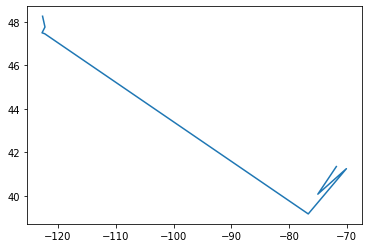

In [97]:
array = np.array(df_paths["coordinates"].iloc[0])
plt.plot(array[:,1],array[:,0])

Centrality

In graph theory and network analysis, indicators of centrality assign numbers or rankings to nodes within a graph corresponding to their network position. Applications include identifying the most influential person(s) in a social network,

In [101]:
sorted_degree_centrality = sorted(nx.degree_centrality(G).items(), key=lambda x: x[1], reverse=True)

In [63]:
sorted_degree_centrality = [x[0] for x in sorted_degree_centrality[0:20]]

In [64]:
#These are the most "central" nodes in the graph
sorted_degree_centrality

['Hartsfield-Jackson Atlanta International',
 'Minneapolis-St Paul International',
 'Denver International',
 "Chicago O'Hare International",
 'Dallas/Fort Worth International',
 'Ted Stevens Anchorage International',
 'Memphis International',
 'Detroit Metro Wayne County',
 'George Bush Intercontinental/Houston',
 'McCarran International',
 'Los Angeles International',
 'Louisville International-Standiford Field',
 'Willow Run',
 'Washington Dulles International',
 'Newark Liberty International',
 'Charlotte Douglas International',
 'Indianapolis International',
 'Bob Hope',
 'Baltimore/Washington International Thurgood Marshall',
 'Miami International']

In [65]:
mask = data["ORIGIN_AIRPORT"].isin(sorted_degree_centrality)
to_florian_dataframe_degree_centrality = data[mask][["ORIGIN_AIRPORT","ORIGIN_COORDINATES"]].drop_duplicates('ORIGIN_AIRPORT', keep='last')
to_florian_dataframe_degree_centrality.to_csv('../../Data/to_florian_dataframe_degree_centrality.csv', index=False)

In [98]:
to_florian_dataframe_degree_centrality

,ORIGIN_AIRPORT,ORIGIN_COORDINATES
155066,Ted Stevens Anchorage International,"[61.1744, -149.996002]"
282277,Hartsfield-Jackson Atlanta International,"[33.6367, -84.428101]"
287002,Detroit Metro Wayne County,"[42.212398529052734, -83.35340118408203]"
288810,Newark Liberty International,"[40.692501, -74.168701]"
290056,Indianapolis International,"[39.7173, -86.294403]"
292722,Los Angeles International,"[33.942501, -118.407997]"
295088,Minneapolis-St Paul International,"[44.882, -93.221802]"
295530,Chicago O'Hare International,"[41.9786, -87.9048]"
297003,Dallas/Fort Worth International,"[32.896801, -97.038002]"
297237,McCarran International,"[36.08010101, -115.1520004]"


C = $\frac{number\hspace{2mm} of\hspace{2mm} closed \hspace{2mm}triplets}{number\hspace{2mm} of \hspace{2mm}all \hspace{2mm}triplets \hspace{2mm}(open \hspace{2mm}and\hspace{2mm} closed)}$


In [66]:
#The average clustering coefficient of the network is 0.56
nx.average_clustering(G)

0.5705020364239568

In [103]:
#Clustering for nodes
clustering = nx.clustering(G)
clustering_sorted = sorted(clustering.items(), key=lambda x: x[1], reverse=True)
clustering_sorted

[('A.J. Eisenberg', 1.0),
 ('Akun Airport', 1.0),
 ('Rutland - Southern Vermont Regional', 1.0),
 ('Park Township', 1.0),
 ('Allegheny County', 1.0),
 ('Ankeny Regional', 1.0),
 ('Artesia Municipal', 1.0),
 ('Augusta State', 1.0),
 ('Brownwood Regional', 1.0),
 ('Morrisville Stowe State', 1.0),
 ('Skagit Regional', 1.0),
 ('Granite Point Ndb', 1.0),
 ('Frank Wiley Field', 1.0),
 ('Havre City-County', 1.0),
 ('Lewistown Municipal', 1.0),
 ('Wokal Field/Glasgow International', 1.0),
 ('Chicago Executive', 1.0),
 ('Executive', 1.0),
 ('Henderson Executive', 1.0),
 ('Lakefront', 1.0),
 ('Livermore Municipal', 1.0),
 ('McClellan-Palomar', 1.0),
 ('Portland Hillsboro', 1.0),
 ('Schenectady County', 1.0),
 ('Scottsdale', 1.0),
 ('William R. Fairchild International', 1.0),
 ('Port Clarence CGS', 1.0),
 ('Broken Bow Municipal Kieth Glaze Field', 1.0),
 ('Brookings Airport', 1.0),
 ('Brunswick Executive', 1.0),
 ('Torrington Municipal', 1.0),
 ('Moody AFB', 1.0),
 ('Chenega Bay', 1.0),
 ('Tatitl

In [141]:
li = []
coef = []
for elm in clustering_sorted:
    if elm[1] in [1,0]:
        li.append(elm[0])
        coef.append(elm[1])

In [142]:
li

['A.J. Eisenberg',
 'Akun Airport',
 'Rutland - Southern Vermont Regional',
 'Park Township',
 'Allegheny County',
 'Ankeny Regional',
 'Artesia Municipal',
 'Augusta State',
 'Brownwood Regional',
 'Morrisville Stowe State',
 'Skagit Regional',
 'Granite Point Ndb',
 'Frank Wiley Field',
 'Havre City-County',
 'Lewistown Municipal',
 'Wokal Field/Glasgow International',
 'Chicago Executive',
 'Executive',
 'Henderson Executive',
 'Lakefront',
 'Livermore Municipal',
 'McClellan-Palomar',
 'Portland Hillsboro',
 'Schenectady County',
 'Scottsdale',
 'William R. Fairchild International',
 'Port Clarence CGS',
 'Broken Bow Municipal Kieth Glaze Field',
 'Brookings Airport',
 'Brunswick Executive',
 'Torrington Municipal',
 'Moody AFB',
 'Chenega Bay',
 'Tatitlek Airport',
 'Chennault International',
 'Decatur Airport',
 'Southeast Iowa Regional',
 'Chicken Airport',
 'Chisana Airport',
 'Circle Hot Springs Airport',
 'Grissom ARB',
 'Coal Creek',
 'Colorado Creek Airport',
 'Columbia Cou

In [143]:
coef

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [144]:
d = {"ORIGIN_AIRPORT": li, "COEFFICIENT": coef}
df_coef = pd.DataFrame(data=d)

In [145]:
#data = pd.merge(data,airport_names_origin, on = ["ORIGIN_AIRPORT_ID"] )

In [146]:
mask = data["ORIGIN_AIRPORT"].isin(li)

In [147]:
to_florian_dataframe = data[mask][["ORIGIN_AIRPORT","ORIGIN_COORDINATES"]].drop_duplicates('ORIGIN_AIRPORT', keep='last')

In [148]:
to_florian_dataframe = pd.merge(to_florian_dataframe, df_coef, on = ["ORIGIN_AIRPORT"])

In [152]:
#to_florian_dataframe = data[mask][["ORIGIN_AIRPORT","ORIGIN_COORDINATES"]].drop_duplicates('ORIGIN_AIRPORT', keep='last')
to_florian_dataframe.to_csv('../../Data/to_florian_clustering_coefficient.csv', index=False)

In [153]:
mask = to_florian_dataframe["ORIGIN_AIRPORT"] == 'Whidbey Island NAS'
to_florian_dataframe[mask]

,ORIGIN_AIRPORT,ORIGIN_COORDINATES,COEFFICIENT
155,Whidbey Island NAS,"[48.351799, -122.655998]",0.0


In [71]:
t = [x[1] for x in clustering_sorted]

The clustering coefficient is following a normal distribution, except for the values 0 and 1

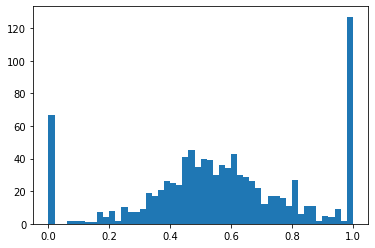

In [72]:
plt.hist(t, bins = 50);

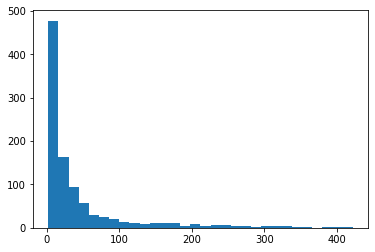

In [73]:
#Degree distribution
def plot_degree_dist(G):
    degrees = [G.degree(n) for n in G.nodes()]
    plt.hist(degrees, bins = 30)
    plt.show()

plot_degree_dist(G)

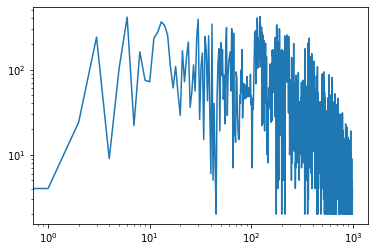

In [74]:
#Degree distribution
def plot_degree_dist(G):
    degrees = [G.degree(n) for n in G.nodes()]
    plt.loglog(degrees)
    plt.show()

plot_degree_dist(G)

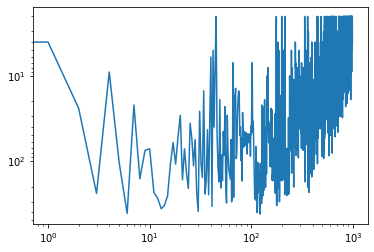

In [75]:
#Degree distribution
#It does not follow the power law
def plot_degree_dist(G):
    degrees = [n[1] for n in G.degree]
    plt.loglog(degrees)
    plt.gca().invert_yaxis()
    plt.show()

plot_degree_dist(G)

In [76]:
#The pagerank is taking the euclidian distance as the weight

In [77]:
pagerank = nx.pagerank(G)
sorted(pagerank.items(), key=lambda x: x[1], reverse=True)

[('Ted Stevens Anchorage International', 0.021211371976194878),
 ('Bob Hope', 0.011895503622702988),
 ('Seattle/Tacoma International', 0.011169427890665795),
 ('Denver International', 0.01111651962156741),
 ('Los Angeles International', 0.010705703350510453),
 ('Fairbanks International', 0.01043926293871789),
 ('McCarran International', 0.009541374309902043),
 ('Minneapolis-St Paul International', 0.009271262092992151),
 ("Chicago O'Hare International", 0.009103984799117965),
 ('Hartsfield-Jackson Atlanta International', 0.008522924618660522),
 ('San Francisco International', 0.008447175891578224),
 ('George Bush Intercontinental/Houston', 0.008124671474273294),
 ('John F. Kennedy International', 0.007833797362680174),
 ('Newark Liberty International', 0.007764421232768935),
 ('Phoenix Sky Harbor International', 0.007656975243253492),
 ('Dallas/Fort Worth International', 0.007645212641706345),
 ('Miami International', 0.007594729969943335),
 ('Memphis International', 0.0074696494236369

In [78]:
graph_test = nx.DiGraph()

In [79]:
graph_test

In [80]:
graph_test.add_node("a",heuristic = 9)
graph_test.add_node("b",heuristic = 7)
graph_test.add_node("c",heuristic = 8)
graph_test.add_node("d",heuristic = 8)
graph_test.add_node("e",heuristic = 0)
graph_test.add_node("s",heuristic = 10)
graph_test.add_node("f",heuristic = 6)
graph_test.add_node("g",heuristic = 3)
graph_test.add_node("h",heuristic = 6)
graph_test.add_node("i",heuristic = 4)
graph_test.add_node("j",heuristic = 4)
graph_test.add_node("k",heuristic = 5)
graph_test.add_node("l",heuristic = 4)

In [81]:
graph_test.add_edge("s","a", weight = 7)
graph_test.add_edge("s","b", weight = 2)
graph_test.add_edge("s","c", weight = 3)
graph_test.add_edge("a","b", weight = 3)
graph_test.add_edge("a","d", weight = 4)
graph_test.add_edge("b","a", weight = 3)
graph_test.add_edge("b","h", weight = 1)
graph_test.add_edge("b","d", weight = 4)
graph_test.add_edge("c","l", weight = 2)
graph_test.add_edge("d","f", weight = 5)
graph_test.add_edge("h","f", weight = 3)
graph_test.add_edge("f","h", weight = 3)
graph_test.add_edge("h","g", weight = 2)
graph_test.add_edge("g","e", weight = 2)

graph_test.add_edge("l","i", weight = 4)
graph_test.add_edge("l","j", weight = 4)
graph_test.add_edge("i","j", weight = 4)
graph_test.add_edge("i","k", weight = 4)
graph_test.add_edge("j","k", weight = 4)
graph_test.add_edge("k","e", weight = 5)

In [82]:
graph_test["c"]

AtlasView({'l': {'weight': 2}})

In [83]:
graph_test

In [84]:
nx.dijkstra_path(graph_test,"s","e")

['s', 'b', 'h', 'g', 'e']

In [85]:
graph_test["c"]

AtlasView({'l': {'weight': 2}})

In [86]:
graph_test.nodes["j"]

{'heuristic': 4}

In [87]:
graph_test["j"]

AtlasView({'k': {'weight': 4}})

In [88]:
class priorityQ():
    def __init__(self):
        self.queue = []
        self.set = set()
        
    def insert(self, obj):
        #print(self.set)
        if obj.node_name in self.set:
            print(obj.node_name, "er allerede i sættet")
            #if obj.
            return 
        if len(self.queue) == 0:
            self.queue.append(obj)
            self.set.add(obj.node_name)
            return
        else:
            for i in range(0,len(self.queue)):
                if self.queue[i].own_combined > obj.own_combined:
                    self.queue.insert(i,obj)
                    self.set.add(obj.node_name)
                    return 
            self.queue.append(obj)
            self.set.add(obj.node_name)
    def pop(self):
        if len(self.queue)  == 0:
            return "queue empty"
        self.set.remove(self.queue[0])
        self.queue.pop(0)
        
    def delete(self,name):
        counter = 0
        #print(name in self.set)
        for elm in self.queue:
            if elm.node_name == name:
                self.set.remove(elm.node_name)
                del self.queue[counter]
            counter += 1
            
    def back_track(self, name):
        L = len(self.queue)
        li = []
        while True:
            name_to_find = name
            for i in range(L):
                if self.queue[i].from_node:
                
                if self.queue[i].node_name == name_to_find:
                    index = i
                    name_to_find = self.queue[index].from_node
                    li.append(self.queue[index].from_node, self.queue[index].own_distance)
                    L = index
                    break
            
            
                

SyntaxError: invalid syntax (<ipython-input-88-7cd260b6a7e5>, line 45)

In [ ]:

class a_star_class():    
    def __init__(self, graph, node_name, from_node, own_distance = float("inf"), own_heuristic = float("inf")):
        self.node_name = node_name
        self.from_node = from_node
        self.own_distance = own_distance
        self.own_heuristic = own_heuristic
        self.own_combined = own_distance + own_heuristic
        dictionary = dict()
        dist = dict()
        heuristic = dict()
        for elm in graph[node_name]:
            #print(graph[node_name])
            dist[elm] = graph[node_name][elm]["weight"]
            heuristic[elm] = graph.nodes[elm]["heuristic"]
        dictionary["heuristic"] = heuristic
        dictionary["distance"] = dist 
        self.neighbors = dictionary
        self.combined = dict(Counter(dictionary["heuristic"])+Counter(dictionary["distance"]))
    def update(self, dist, from_node):
        self.own_distance = dist
        self.own_combined = self.own_distance + self.own_heuristic
        self.from_node = from_node
       
    
    def info(self):
        return ("Name: {} \nfrom_node: {} \nDistance: {} \nHeuristic: {} \nCombined: {} \nOwn_distance: {}, \nOwn_heuristic: {}, \nOwn_combined: {}".format(self.node_name, self.from_node,self.neighbors["distance"], self.neighbors["heuristic"], self.combined,self.own_distance, self.own_heuristic, self.own_combined))
        
test = a_star_class(graph_test, "c", None)

In [ ]:
def a_star(g,start,goal):
    priorityQueue = priorityQ()
    #Since our starting node has no travel, we initiate it 
    #with a distance of 0
    start_node = a_star_class(g,start,None,0,10)
    #start_node.info()
    priorityQueue.insert(start_node)
    #nd_node = a_star_class(g,"b","s",2,7)
    #rd_node =  a_star_class(g,"a","s",7,9)
    #priorityQueue.insert(nd_node)
    #priorityQueue.insert(rd_node)
    
        
        
    while len(priorityQueue.queue) != 0:
        obj_list = []
        for elm in priorityQueue.queue[0].combined:
            from_node = priorityQueue.queue[0].node_name
            to_node = elm
            heuristic =  priorityQueue.queue[0].neighbors["heuristic"][elm]
            dist = priorityQueue.queue[0].neighbors["distance"][elm]
            obj_list.append(a_star_class(g,to_node,from_node,dist,heuristic))
            
        for elm in obj_list:
            priorityQueue.insert(elm)
        break
    
    priorityQueue.delete("s")
    priorityQueue.insert(a_star_class(g,"a","b",5,9))
    #priorityQueue.queue[2].update(5, "b")
    for elm in priorityQueue.queue:
        
        print(elm.info())
        
a_star(graph_test, "s", "e")


In [ ]:
print(test.info())

In [ ]:
test = priorityQ()

In [ ]:
for elm in graph_test.nodes:
    print(graph_test[elm])

In [ ]:
test.insert(7)

In [ ]:
test.queue

In [ ]:
test.insert(9)

In [ ]:
test.queue

In [ ]:
test.insert(0)
test.queue

In [ ]:
test.insert(1)

In [ ]:
test.queue

In [ ]:
test.pop()

In [ ]:
test.queue

In [ ]:
test_data = random.sample(range(1000), 1000)

In [ ]:
[test.insert(elm) for elm in test_data]

In [ ]:
test.queue

In [ ]:
li = [4,6,8,9]

In [ ]:
li.insert(0,9)

In [ ]:
li

In [ ]:
idk['Aniak Airport']

In [ ]:
kat["San Francisco International"]

In [ ]:
idk.nodes["Fairbanks International"]

In [ ]:
#according to wikipedia https://en.wikipedia.org/wiki/Cruise_(aeronautics)
#The uptimal cruise speed of planes are 880–926.

In [ ]:
G.add_node(1, times = {
    "0000": False,
    "0100": True,
    "0200": False
}, coordinates = [1,2])

In [ ]:
G.edges

In [ ]:
G.nodes

In [ ]:
G.nodes[1]

In [ ]:
G.add_edge(1,2)

In [ ]:
G.add_edge("AK","AZ")

In [ ]:
G.edges

In [ ]:
nx.set_node_attributes(G, 1, "betweenness")
nx.set_node_attributes(G, 99, "længde")

In [ ]:
G.nodes[1]

In [ ]:
nx.set_node_attributes(G,1,coordinates = [9,9])

In [ ]:
temp = {
    "0000": False,
    "0100": True,
    "0200": False
}

In [ ]:
test = data.groupby(["ORIGIN_CITY_NAME","DEST_CITY_NAME"])

In [ ]:
test

In [ ]:
airport_origin_coordinates

In [ ]:
#for elm in data.iterrows():
#    n1 = str(elm[1][9])
#    n2 = str(elm[1][10])
#    G.add_edge(n1,n2,data = elm[1])
    

In [ ]:
r = lambda: random.randint(0,255)
colors = set()
city_colors = dict()
for elm in grouped.iterrows():
    
    c = '#%02X%02X%02X' % (r(),r(),r())
    if elm[0][0] not in city_colors:
        while True:
            if c not in colors:
                city_colors[elm[0][0]] = c
                colors.add(c)
            break


In [ ]:
city_colors

In [ ]:
G = nx.MultiDiGraph()
counter = 0
for i in grouped.iterrows():
    
    G.add_edge(i[0][0],i[0][1],data = i[1], color = city_colors[i[0][0]])
    if counter == 1000:
        break
    counter += 1

In [ ]:
colors = nx.get_edge_attributes(G,'color').values()

In [ ]:
#plt.rcParams["figure.figsize"] = (100,100)
#nx.draw(G,with_labels = True,edge_color = colors)
#plt.savefig("../../PNGfiles/tofu.png")